In [1]:
import os
# os.environ['PYTHON_JULIACALL_HANDLE_SIGNALS'] = 'yes'

import src.vorpy.vorpy as vp
# import vorpy as vp
# import vormake as vmk
import numpy as np
import matplotlib.pyplot as plt

/home/crashoverride/miniforge3/envs/2024_05_work/lib/python3.12/site-packages/juliacall/__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
* Creating new Julia namespace...
* Getting path to julia_fns...
* Path to julia_fns: /home/crashoverride/Dropbox/code/vorpy/julia_fns
* Setting JULIA_FNS variable in Julia...
* Trying to run julia_env.jl in /home/crashoverride/Dropbox/code/vorpy/julia_fns...
* Julia environment variables loaded for Vorpy.
* Activating vorpy Julia project...
* Loading CUDA Biot-Savart solver (this may take a few seconds)...


  Activating project at `~/Dropbox/code/vorpy/julia_fns`


Max number of thread: 384
Register usage: 138
* CUDA Biot-Savart solver loaded.
* Loading CPU Biot-Savart solver...
Memory usage: (local = 480, shared = 0, constant = 0)
-> Elapsed time for importing weighted_biot_savart_solver_one_field_point.jl: 0.14473281200000002
* CPU Biot-Savart solver loaded.
!! User API to Biot-Savart solvers set up. Available devices: ['cuda', 'cpu']


In [2]:
# vmk.vortex_ring(100, [0, 0, 0], 1)

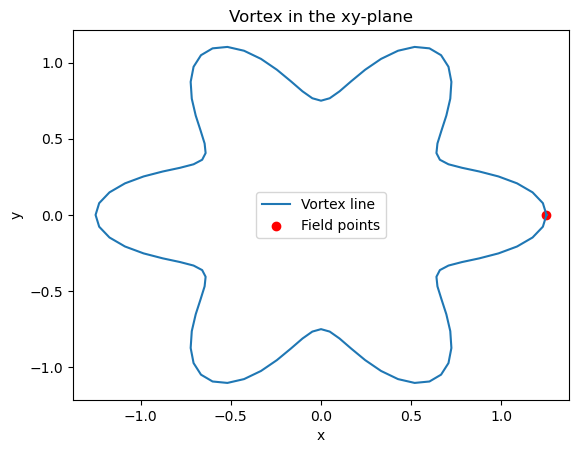

In [26]:
###### Make a vortex ######
NUMSEGS = 100
phi = np.linspace(0, 2*np.pi, NUMSEGS+1)
r = 1 + 0.25 * np.cos(6*phi)
vppsx = r*np.cos(phi)
vppsy = r*np.sin(phi)
vpps = np.zeros((NUMSEGS+1, 3), dtype=float)
vpps[:, 0] = vppsx
vpps[:, 1] = vppsy
# Set the first and last point to be the same
# to close the vortex line
vpps[-1, :] = vpps[0, :]

# Set the core radii and circulations
crads = np.ones(NUMSEGS+1, dtype=float)
circs = np.ones(NUMSEGS+1, dtype=float)

# Plot the vortex line
plt.plot(vpps[:, 0], vpps[:, 1], label='Vortex line')
plt.title('Vortex in the xy-plane')
plt.xlabel('x')
plt.ylabel('y')


###### Make field points ######
fps = vpps[0, :].reshape(1, 3)
# fps = vpps.copy() 
# fps = np.zeros((3, 3), dtype=float)
# fps[0, :] = vpps[0, :]
# fps[1, :] = vpps[9, :]
# fps[2, :] = vpps[21, :]

# Plot the field points
plt.scatter(fps[:, 0], fps[:, 1], color='r', label='Field points')

plt.legend()
plt.show()

In [23]:
# vels = vp.wbs_solve(fps,
#                     vpps,
#                     crads,
#                     circs,
#                     device='cuda',
#                     stepsizescalar=0.001)

# print('vels:\n', vels)

sizearray = np.linspace(1e-4, 0.4, 1000)

vels = []
for ssize in sizearray:
    vels.append(vp.wbs_solve(fps,
                        vpps,
                        crads,
                        circs,
                        device='cuda',
                        stepsizescalar=ssize))

vels = np.array(vels)

In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_solve using device: cuda
In wbs_s

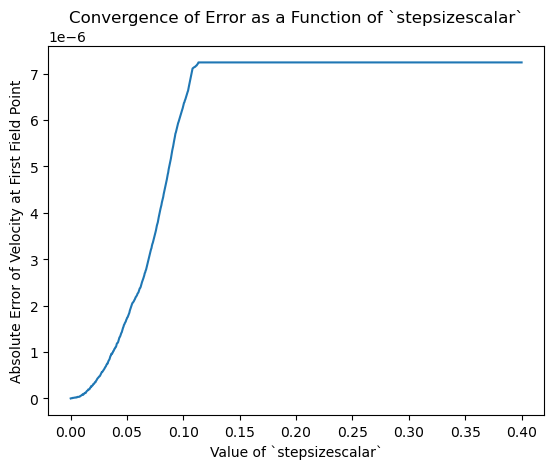

In [24]:
plt.plot(sizearray, np.abs(vels[:, 0, 2] - vels[0, 0, 2]))  # , 'o-')
plt.xlabel('Value of `stepsizescalar`')
plt.ylabel('Absolute Error of Velocity at First Field Point')
plt.title('Convergence of Error as a Function of `stepsizescalar`')
plt.show()